In [1]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import numpy
import random
torch.manual_seed(2)
np.random.seed(2)
random.seed(2)

In [2]:
# 生成两个数据集，各有200个数据，X^1是维度为2，X^2维度为10，其中每个数据中前100个标签为0，后100个标签为1。
X1, y1 = make_moons(200, noise=0.2, shuffle=False, random_state=7)
X2, y2 = make_blobs(n_samples=200, n_features=10, shuffle=False, centers=2, center_box=(-10, 10), random_state=7)

# 对两个数据集进行降维，用KMeans，聚为两类
km1 = KMeans(n_clusters=2, random_state=0)
km2 = KMeans(n_clusters=2, random_state=0)
a1 = km1.fit(X1)
a2 = km2.fit(X2)

# 这是每个聚类的中心
X1_center_1 = km1.cluster_centers_[0, :]
X1_center_2 = km1.cluster_centers_[1, :]
X2_center_1 = km2.cluster_centers_[0, :]
X2_center_2 = km2.cluster_centers_[1, :]

# 用聚类后每个点到聚类中心的欧式距离来算出属于某聚类的概率，从而生成A矩阵
def create_A_matrix(X, center1, center2):
    A = np.zeros((200, 2))

    for i in range(200):
        dis1 = np.sqrt(np.sum(np.square(X[i, :] - center1)))
        dis2 = np.sqrt(np.sum(np.square(X[i, :] - center2)))
        A[i, 0] = dis1 / (dis1 + dis2)
        A[i, 1] = dis2 / (dis1 + dis2)

    return A

# 生成A矩阵
A1 = np.mat(create_A_matrix(X1, X1_center_1, X1_center_2))
A2 = np.mat(create_A_matrix(X2, X2_center_1, X2_center_2))

#将矩阵变为tensor
X1 = torch.from_numpy(X1).double()
X2 = torch.from_numpy(X2).double()
A1 = torch.from_numpy(A1).double()
A2 = torch.from_numpy(A2).double()

y = y1

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

#精确度分析
def acc(y_pred, y_true):
    return accuracy_score(y_true, y_pred, normalize=True)

#线性分类器
def LR(X_train, y_train):
    clf = LogisticRegression(penalty='l2')
    clf.fit(X_train, y_train)
    return clf.predict(X_train)

#非线性分类器
def svm(X_train, y_train):
    nlc = SVC(kernel='rbf')
    nlc.fit(X_train, y_train)
    return nlc

In [4]:
#CCA
class linear_cca():
    def __init__(self):
        self.w = [None, None]
        self.m = [None, None]

    def fit(self, H1, H2, outdim_size):
        """
        An implementation of linear CCA
        # Arguments:
            H1 and H2: the matrices containing the data for view 1 and view 2. Each row is a sample.
            outdim_size: specifies the number of new features
        # Returns
            A and B: the linear transformation matrices
            mean1 and mean2: the means of data for both views
        """
        r1 = 1e-4
        r2 = 1e-4

        m = H1.shape[0]
        o1 = H1.shape[1]
        o2 = H2.shape[1]

        self.m[0] = numpy.mean(H1, axis=0)
        self.m[1] = numpy.mean(H2, axis=0)
        H1bar = H1 - numpy.tile(self.m[0], (m, 1))
        H2bar = H2 - numpy.tile(self.m[1], (m, 1))

        SigmaHat12 = (1.0 / (m - 1)) * numpy.dot(H1bar.T, H2bar)
        SigmaHat11 = (1.0 / (m - 1)) * numpy.dot(H1bar.T,
                                                 H1bar) + r1 * numpy.identity(o1)
        SigmaHat22 = (1.0 / (m - 1)) * numpy.dot(H2bar.T,
                                                 H2bar) + r2 * numpy.identity(o2)

        [D1, V1] = numpy.linalg.eigh(SigmaHat11)
        [D2, V2] = numpy.linalg.eigh(SigmaHat22)
        SigmaHat11RootInv = numpy.dot(
            numpy.dot(V1, numpy.diag(D1 ** -0.5)), V1.T)
        SigmaHat22RootInv = numpy.dot(
            numpy.dot(V2, numpy.diag(D2 ** -0.5)), V2.T)

        Tval = numpy.dot(numpy.dot(SigmaHat11RootInv,
                                   SigmaHat12), SigmaHat22RootInv)

        [U, D, V] = numpy.linalg.svd(Tval)
        V = V.T
        self.w[0] = numpy.dot(SigmaHat11RootInv, U[:, 0:outdim_size])
        self.w[1] = numpy.dot(SigmaHat22RootInv, V[:, 0:outdim_size])
        D = D[0:outdim_size]

    def _get_result(self, x, idx):
        result = x - self.m[idx].reshape([1, -1]).repeat(len(x), axis=0)
        result = numpy.dot(result, self.w[idx])
        return result

    def test(self, H1, H2):
        return self._get_result(H1, 0), self._get_result(H2, 1)

In [5]:
#搭建网络
class MlpNet(nn.Module):
    def __init__(self, layer_sizes, input_size):
        super(MlpNet, self).__init__()
        layers = []
        layer_sizes = [input_size] + layer_sizes
        for l_id in range(len(layer_sizes) - 1):
            if l_id == len(layer_sizes) - 2:
                layers.append(nn.Sequential(
                    nn.BatchNorm1d(num_features=layer_sizes[l_id], affine=False),
                    nn.Linear(layer_sizes[l_id], layer_sizes[l_id + 1]),
                ))
            else:
                layers.append(nn.Sequential(
                    nn.Linear(layer_sizes[l_id], layer_sizes[l_id + 1]),
                    nn.Sigmoid(),
                    nn.BatchNorm1d(num_features=layer_sizes[l_id + 1], affine=False),
                ))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [6]:
#搭建DCCA模型
class DeepCCA(nn.Module):
    def __init__(self, layer_sizes1, layer_sizes2, input_size1, input_size2, outdim_size, use_all_singular_values, device=torch.device('cpu')):
        super(DeepCCA, self).__init__()
        self.model1 = MlpNet(layer_sizes1, input_size1).double()
        self.model2 = MlpNet(layer_sizes2, input_size2).double()

        self.loss = cca_loss(outdim_size, use_all_singular_values, device).loss

    def forward(self, x1, x2):
        """

        x1, x2 are the vectors needs to be make correlated
        dim=[batch_size, feats]

        """
        # feature * batch_size
        output1 = self.model1(x1)
        output2 = self.model2(x2)

        return output1, output2

In [7]:
#Loss(Corr)
class cca_loss():
    def __init__(self, outdim_size, use_all_singular_values, device):
        self.outdim_size = outdim_size
        self.use_all_singular_values = use_all_singular_values
        self.device = device
        # print(device)

    def loss(self, H1, H2):
        """

        It is the loss function of CCA as introduced in the original paper. There can be other formulations.

        """

        r1 = 1e-3
        r2 = 1e-3
        eps = 1e-9

        H1, H2 = H1.t(), H2.t()
        # assert torch.isnan(H1).sum().item() == 0
        # assert torch.isnan(H2).sum().item() == 0

        o1 = o2 = H1.size(0)

        m = H1.size(1)
#         print(H1.size())

        H1bar = H1 - H1.mean(dim=1).unsqueeze(dim=1)
        H2bar = H2 - H2.mean(dim=1).unsqueeze(dim=1)
        # assert torch.isnan(H1bar).sum().item() == 0
        # assert torch.isnan(H2bar).sum().item() == 0

        SigmaHat12 = (1.0 / (m - 1)) * torch.mm(H1bar, H2bar.t())
        SigmaHat11 = (1.0 / (m - 1)) * torch.mm(H1bar,
                                                    H1bar.t()) + r1 * torch.eye(o1, device=self.device)
        SigmaHat22 = (1.0 / (m - 1)) * torch.mm(H2bar,
                                                    H2bar.t()) + r2 * torch.eye(o2, device=self.device)
        # assert torch.isnan(SigmaHat11).sum().item() == 0
        # assert torch.isnan(SigmaHat12).sum().item() == 0
        # assert torch.isnan(SigmaHat22).sum().item() == 0

        # Calculating the root inverse of covariance matrices by using eigen decomposition
        [D1, V1] = torch.symeig(SigmaHat11, eigenvectors=True)
        [D2, V2] = torch.symeig(SigmaHat22, eigenvectors=True)
        # assert torch.isnan(D1).sum().item() == 0
        # assert torch.isnan(D2).sum().item() == 0
        # assert torch.isnan(V1).sum().item() == 0
        # assert torch.isnan(V2).sum().item() == 0

        # Added to increase stability
        posInd1 = torch.gt(D1, eps).nonzero()[:, 0]
        D1 = D1[posInd1]
        V1 = V1[:, posInd1]
        posInd2 = torch.gt(D2, eps).nonzero()[:, 0]
        D2 = D2[posInd2]
        V2 = V2[:, posInd2]
        # print(posInd1.size())
        # print(posInd2.size())

        SigmaHat11RootInv = torch.mm(
            torch.mm(V1, torch.diag(D1 ** -0.5)), V1.t())
        SigmaHat22RootInv = torch.mm(
            torch.mm(V2, torch.diag(D2 ** -0.5)), V2.t())

        Tval = torch.mm(torch.mm(SigmaHat11RootInv,
                                         SigmaHat12), SigmaHat22RootInv)
#         print(Tval.size())

        if self.use_all_singular_values:
            # all singular values are used to calculate the correlation
            tmp = torch.mm(Tval.t(), Tval)
            corr = torch.trace(torch.sqrt(tmp))
            # assert torch.isnan(corr).item() == 0
        else:
            # just the top self.outdim_size singular values are used
            trace_TT = torch.mm(Tval.t(), Tval)
            trace_TT = torch.add(trace_TT, (torch.eye(trace_TT.shape[0])*r1).to(self.device)) # regularization for more stability
            U, V = torch.symeig(trace_TT, eigenvectors=True)
            U = torch.where(U>eps, U, (torch.ones(U.shape).double()*eps).to(self.device))
            U = U.topk(self.outdim_size)[0]
            corr = torch.sum(torch.sqrt(U))



        return -corr

In [8]:
class Solver():
    def __init__(self, model, linear_cca, outdim_size, epoch_num, learning_rate, reg_par,
                 device=torch.device('cpu')):
        self.model = nn.DataParallel(model)
        self.model.to(device)
        self.epoch_num = epoch_num
        self.loss = model.loss
        self.optimizer = torch.optim.RMSprop(
            self.model.parameters(), lr=learning_rate, weight_decay=reg_par)
        self.device = device

        self.linear_cca = linear_cca

        self.outdim_size = outdim_size


    def fit(self, x1, x2, tst1 = None, tst2 = None):

        x1.to(self.device)
        x2.to(self.device)
        
        if tst1 is not None and tst2 is not None:
            tst1.to(self.device)
            tst2.to(self.device)

        train_losses = []
        for epoch in range(self.epoch_num):
            self.model.train()
            self.optimizer.zero_grad()
            batch_x1 = x1
            batch_x2 = x2
            o1, o2 = self.model(batch_x1, batch_x2)
            loss = self.loss(o1, o2)
            train_losses.append(loss.item())
            loss.backward()
            self.optimizer.step()
            train_loss = np.mean(train_losses)
            print('Epoch:', epoch + 1, '    Loss:', train_loss)
            if epoch % 100 == 0:
                o1_ = o1.cpu().detach().numpy()
                o2_ = o2.cpu().detach().numpy()
                #visualization_LR(o1_, y, 'View 1')
                #visualization_LR(o2_, y, 'View 2')
        # train_linear_cca
        if self.linear_cca is not None:
            _, outputs = self._get_outputs(x1, x2)
            self.train_linear_cca(outputs[0], outputs[1])


    def test(self, x1, x2, use_linear_cca=False):
        with torch.no_grad():
            losses, outputs = self._get_outputs(x1, x2)

            if use_linear_cca:

                outputs = self.linear_cca.test(outputs[0], outputs[1])
                return np.mean(losses), outputs
            else:
                return np.mean(losses)

    def train_linear_cca(self, x1, x2):
        self.linear_cca.fit(x1, x2, self.outdim_size)

    def _get_outputs(self, x1, x2):
        with torch.no_grad():
            self.model.eval()
            losses = []
            outputs1 = []
            outputs2 = []
            o1, o2 = self.model(x1, x2)
            outputs1.append(o1)
            outputs2.append(o2)
            loss = self.loss(o1,o2)
            losses.append(loss.item())

        outputs = [torch.cat(outputs1, dim=0).cpu().numpy(),
                   torch.cat(outputs2, dim=0).cpu().numpy()]
        return losses, outputs

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

#精确度分析
def acc(y_pred, y_true):
    return accuracy_score(y_true, y_pred, normalize=True)

# 线性分类器
def LR(X_train, y_train, y_test=None):
    clf = LogisticRegression(penalty='l2')
    clf.fit(X_train, y_train)  
    return clf.coef_, clf.intercept_, clf.predict(X_train)

#预留20%为测试集，在测试集上的精度
def LR_2(Train_x, Train_y):
    train_x, test_x, train_y, test_y = train_test_split(Train_x, Train_y, test_size=0.2, random_state=2)
    clf1 = LogisticRegression(penalty='l2')
    clf1.fit(train_x, train_y)
    pred_y = clf1.predict(test_x)
    acc = accuracy_score(test_y, pred_y, normalize=True)
    return acc

#非线性分类器
def svm(X_train, y_train):
    nlc = SVC(kernel='rbf')
    nlc.fit(X_train, y_train)
    return nlc

def svm_2(Train_x, Train_y):
    train_x, test_x, train_y, test_y = train_test_split(Train_x, Train_y, test_size=0.2, random_state=2)
    nlc1 = SVC(kernel='rbf')
    nlc1.fit(train_x, train_y)
    pred_y = nlc1.predict(test_x)
    acc = accuracy_score(test_y, pred_y, normalize=True)
    return acc


# 可视化
def visualization_LR(X, y, title):
    weight = LR(X, y)[0]
    bias = LR(X, y)[1]
    dataArr = np.array(X)
    xcord1 = [];
    ycord1 = []
    xcord2 = [];
    ycord2 = []
    for i in range(y.shape[0]):
        if int(y[i]) == 1:
            xcord1.append(dataArr[i, 0]);
            ycord1.append(dataArr[i, 1])
        else:
            xcord2.append(dataArr[i, 0]);
            ycord2.append(dataArr[i, 1])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xcord1, ycord1, s=30, c='red', marker='s')
    ax.scatter(xcord2, ycord2, s=30, c='green')
    x_1 = np.arange(-1, 2, 0.01)
    a = -weight[0, 0] / weight[0, 1]
    b = -bias / weight[0, 1]
    #y_1 = a * x_1 + b
    # -weights[0]
    #ax.plot(x_1, y_1)
    plt.title(title)
    plt.show()
    
def visualization_SVM(X, y, title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))
    xy = np.vstack([xx.ravel(), yy.ravel()]).T
    Z = svm(X, y).decision_function(xy).reshape(xx.shape)
    #plt.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max(),), aspect='auto',
               #origin='lower', cmap=plt.cm.PuOr_r)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, linestyle='-')
    plt.scatter(X[:, 0].tolist(), X[:, 1].tolist(), s=30, c=y, cmap=plt.cm.Paired, edgecolors='k')
    plt.title(title)
    plt.show()
    

Epoch: 1     Loss: -0.13254770372673605
Epoch: 2     Loss: -0.19356691707939894
Epoch: 3     Loss: -0.24039357469590508
Epoch: 4     Loss: -0.28586723357711785
Epoch: 5     Loss: -0.35011744114069804
Epoch: 6     Loss: -0.3920631540903776
Epoch: 7     Loss: -0.4425281614974953
Epoch: 8     Loss: -0.4733161777337109
Epoch: 9     Loss: -0.4980047814211052
Epoch: 10     Loss: -0.5320841470198819
Epoch: 11     Loss: -0.5587304342939293
Epoch: 12     Loss: -0.582315213115402
Epoch: 13     Loss: -0.6084913818659095
Epoch: 14     Loss: -0.6335676509800248
Epoch: 15     Loss: -0.6549130176655603
Epoch: 16     Loss: -0.6694376201980073
Epoch: 17     Loss: -0.6885721735198759
Epoch: 18     Loss: -0.7042452630653726
Epoch: 19     Loss: -0.7162218474244584
Epoch: 20     Loss: -0.7296166434854918
Epoch: 21     Loss: -0.7443471101431556
Epoch: 22     Loss: -0.7575574574451749
Epoch: 23     Loss: -0.7697878740556862
Epoch: 24     Loss: -0.7821124299191338
Epoch: 25     Loss: -0.7951678141519777
Epoch

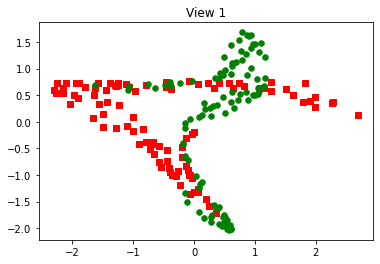

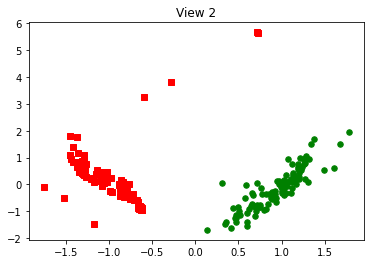

<ipython-input-9-6bf040cb2983>:75: UserWarning: The following kwargs were not used by contour: 'linestyle'
  plt.contour(xx, yy, Z, levels=[0], linewidths=2, linestyle='-')


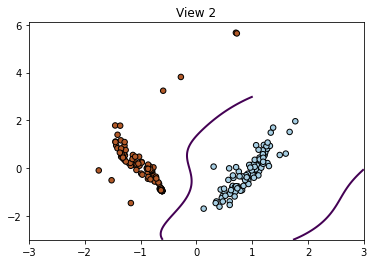

<ipython-input-9-6bf040cb2983>:75: UserWarning: The following kwargs were not used by contour: 'linestyle'
  plt.contour(xx, yy, Z, levels=[0], linewidths=2, linestyle='-')


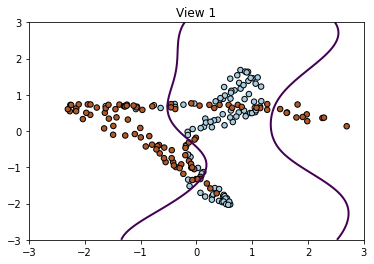

线性LR在X1数据集上的精确度： 74.5 %
非线性SVM在X1数据集上的精确度： 81.5 %
线性LR在X2数据集上的精确度： 100.0 %
非线性SVM在X2数据集上的精确度： 100.0 %
*******************************************************************
acc1LR 0.625
acc2LR 1.0
acc1SVM 0.7
acc2SVM 1.0


In [11]:
if __name__ == '__main__':

    device = torch.device('cuda')
    #输出的维度
    outdim_size = 2

    # 两个view的输入
    input_shape1 = 2
    input_shape2 = 10

    # 网络架构设置
    layer_sizes1 = [20, 40, 20, outdim_size]
    layer_sizes2 = [20, 40, 20, outdim_size]

    # 超参数设置
    learning_rate = 1e-3
    epoch_num = 2000
    reg_par = 1e-5
    use_all_singular_values = False
    apply_linear_cca = True

    model = DeepCCA(layer_sizes1, layer_sizes2, input_shape1,
                    input_shape2, outdim_size, use_all_singular_values, device=device).double()
    l_cca = None
    if apply_linear_cca:
        l_cca = linear_cca()
    solver = Solver(model, l_cca, outdim_size, epoch_num, learning_rate, reg_par, device=device)
    train1, train2 = X1, X2

    solver.fit(train1, train2)

    loss, outputs = solver.test(train1, train2, apply_linear_cca)

    #可视化X1映射到隐空间中的状态，尾数1代表View 1
    visualization_LR(outputs[0], y1, 'View 1')
    #可视化X2映射到隐空间中的状态，尾数2代表View 2
    visualization_LR(outputs[1], y1, 'View 2')
    
    visualization_SVM(outputs[1], y1, 'View 2')
    visualization_SVM(outputs[0], y1, 'View 1')
    print("线性LR在X1数据集上的精确度：", acc(LR(numpy.mat(outputs[0]), y1)[2], y1) * 100, '%')
    print("非线性SVM在X1数据集上的精确度：", acc(svm(outputs[0], y1).predict(outputs[0]), y1) * 100, '%')
    print("线性LR在X2数据集上的精确度：", acc(LR(numpy.mat(outputs[1]), y1)[2], y1) * 100, '%')
    print("非线性SVM在X2数据集上的精确度：", acc(svm(outputs[1], y1).predict(outputs[1]), y1) * 100, '%')
    print("*******************************************************************")
    print("acc1LR", LR_2(outputs[0], y1))
    print("acc2LR", LR_2(outputs[1], y1))
    print("acc1SVM", svm_2(outputs[0], y1))
    print("acc2SVM", svm_2(outputs[1], y1))

Epoch: 1     Loss: -0.4843452168434845
Epoch: 2     Loss: -0.7001523147952317
Epoch: 3     Loss: -0.7952434034824734
Epoch: 4     Loss: -0.8512066083068194
Epoch: 5     Loss: -0.8815527693958524
Epoch: 6     Loss: -0.9073481946635504
Epoch: 7     Loss: -0.928565269967703
Epoch: 8     Loss: -0.9470788659729035
Epoch: 9     Loss: -0.9637605968680598
Epoch: 10     Loss: -0.9792724835162654
Epoch: 11     Loss: -0.99034340554948
Epoch: 12     Loss: -0.9953039529482152
Epoch: 13     Loss: -1.0019310519331306
Epoch: 14     Loss: -1.009148613620334
Epoch: 15     Loss: -1.0164765670333884
Epoch: 16     Loss: -1.0241331127803575
Epoch: 17     Loss: -1.0322151565996212
Epoch: 18     Loss: -1.0405316230619184
Epoch: 19     Loss: -1.0468591732123225
Epoch: 20     Loss: -1.0498030009566612
Epoch: 21     Loss: -1.0528493614404966
Epoch: 22     Loss: -1.0575925679820495
Epoch: 23     Loss: -1.0625878265704887
Epoch: 24     Loss: -1.0677733956922342
Epoch: 25     Loss: -1.0732223098093043
Epoch: 26    

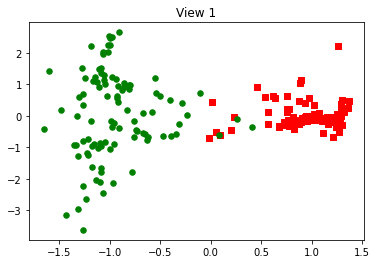

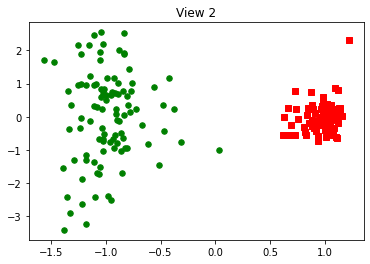

<ipython-input-11-016707e4b96d>:51: UserWarning: The following kwargs were not used by contour: 'linestyle'
  plt.contour(xx, yy, Z, levels=[0], linewidths=2, linestyle='-')


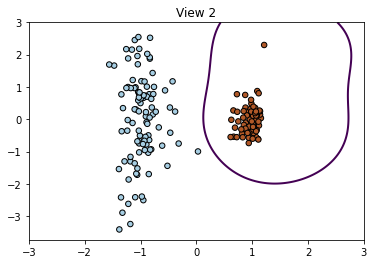

<ipython-input-11-016707e4b96d>:51: UserWarning: The following kwargs were not used by contour: 'linestyle'
  plt.contour(xx, yy, Z, levels=[0], linewidths=2, linestyle='-')


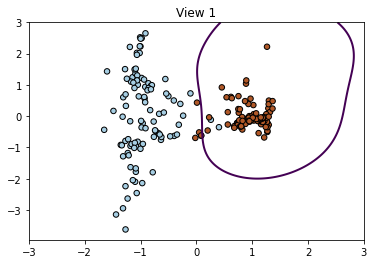

线性LR在X1数据集上的精确度： 97.5 %
非线性SVM在X1数据集上的精确度： 97.0 %
线性LR在X2数据集上的精确度： 100.0 %
非线性SVM在X2数据集上的精确度： 100.0 %


In [12]:
if __name__ == '__main__':

    device = torch.device('cpu')
    #输出的维度
    outdim_size = 2

    # 两个view的输入
    input_shape1 = 2
    input_shape2 = 10

    # 网络架构设置
    layer_sizes1 = [20, 40, 20, outdim_size]
    layer_sizes2 = [20, 40, 20, outdim_size]

    # 超参数设置
    learning_rate = 1e-3
    epoch_num = 1000
    reg_par = 1e-5
    use_all_singular_values = False
    apply_linear_cca = True

    model = DeepCCA(layer_sizes1, layer_sizes2, input_shape1,
                    input_shape2, outdim_size, use_all_singular_values, device=device).double()
    l_cca = None
    if apply_linear_cca:
        l_cca = linear_cca()
    solver = Solver(model, l_cca, outdim_size, epoch_num,
                    learning_rate, reg_par, device=device)
    train1, train2 = X1, X2

    solver.fit(train1, train2)

    loss, outputs = solver.test(train1, train2, apply_linear_cca)

    #可视化X1映射到隐空间中的状态，尾数1代表View 1
    visualization_LR(outputs[0], y1, 'View 1')
    
    #可视化X2映射到隐空间中的状态，尾数2代表View 2
    visualization_LR(outputs[1], y1, 'View 2')
    visualization_SVM(outputs[1], y1, 'View 2')
    visualization_SVM(outputs[0], y1, 'View 1')
    print("线性LR在X1数据集上的精确度：", acc(LR(numpy.mat(outputs[0]), y1)[2], y1) * 100, '%')
    print("非线性SVM在X1数据集上的精确度：", acc(svm(outputs[0], y1).predict(outputs[0]), y1) * 100, '%')
    print("线性LR在X2数据集上的精确度：", acc(LR(numpy.mat(outputs[1]), y1)[2], y1) * 100, '%')
    print("非线性SVM在X2数据集上的精确度：", acc(svm(outputs[1], y1).predict(outputs[1]), y1) * 100, '%')

Epoch: 1     Loss: -0.6367681077564656
Epoch: 2     Loss: -0.7804483746934596
Epoch: 3     Loss: -0.841637397195761
Epoch: 4     Loss: -0.882314602017888
Epoch: 5     Loss: -0.9125700452943128
Epoch: 6     Loss: -0.9372832264029274
Epoch: 7     Loss: -0.957983168666896
Epoch: 8     Loss: -0.9662849172269704
Epoch: 9     Loss: -0.978486334837434
Epoch: 10     Loss: -0.9919870217613547
Epoch: 11     Loss: -1.006333999339711
Epoch: 12     Loss: -1.0204184146707218
Epoch: 13     Loss: -1.0344646150715087
Epoch: 14     Loss: -1.0362264629245541
Epoch: 15     Loss: -1.0434526773424235
Epoch: 16     Loss: -1.0516311032731385
Epoch: 17     Loss: -1.0615869537094558
Epoch: 18     Loss: -1.0711487830308304
Epoch: 19     Loss: -1.0809414737830882
Epoch: 20     Loss: -1.0914917171776766
Epoch: 21     Loss: -1.1006153557831462
Epoch: 22     Loss: -1.1031911403368149
Epoch: 23     Loss: -1.111762782492524
Epoch: 24     Loss: -1.120786324862226
Epoch: 25     Loss: -1.1292565913263375
Epoch: 26     Lo

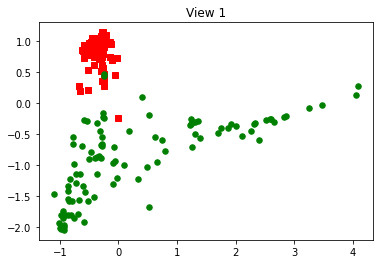

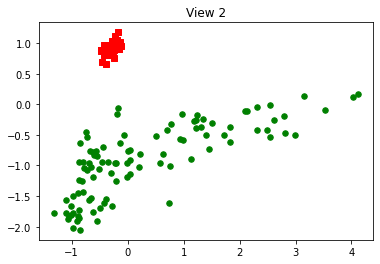

<ipython-input-9-488c80fc7f86>:42: UserWarning: The following kwargs were not used by contour: 'linestyle'
  plt.contour(xx, yy, Z, levels=[0], linewidths=2, linestyle='-')


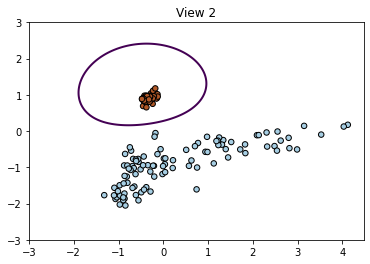

<ipython-input-9-488c80fc7f86>:42: UserWarning: The following kwargs were not used by contour: 'linestyle'
  plt.contour(xx, yy, Z, levels=[0], linewidths=2, linestyle='-')


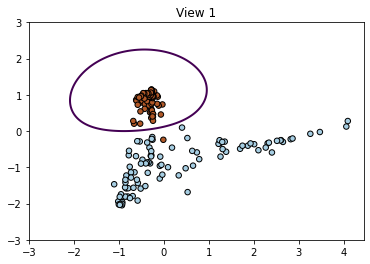

线性LR在X1数据集上的精确度： 98.5 %
非线性SVM在X1数据集上的精确度： 98.5 %
线性LR在X2数据集上的精确度： 100.0 %
非线性SVM在X2数据集上的精确度： 100.0 %


In [13]:

if __name__ == '__main__':

    device = torch.device('cpu')
    #输出的维度
    outdim_size = 2

    # 两个view的输入
    input_shape1 = 2
    input_shape2 = 10

    # 网络架构设置
    layer_sizes1 = [20, 40, 20, outdim_size]
    layer_sizes2 = [20, 40, 20, outdim_size]

    # 超参数设置
    learning_rate = 1e-3
    epoch_num = 1000
    reg_par = 1e-5
    use_all_singular_values = False
    apply_linear_cca = True

    model = DeepCCA(layer_sizes1, layer_sizes2, input_shape1,
                    input_shape2, outdim_size, use_all_singular_values, device=device).double()
    l_cca = None
    if apply_linear_cca:
        l_cca = linear_cca()
    solver = Solver(model, l_cca, outdim_size, epoch_num,
                    learning_rate, reg_par, device=device)
    train1, train2 = X1, X2

    solver.fit(train1, train2)

    loss, outputs = solver.test(train1, train2, apply_linear_cca)

     #可视化X1映射到隐空间中的状态，尾数1代表View 1
    visualization_LR(outputs[0], y1, 'View 1')
    
    #可视化X2映射到隐空间中的状态，尾数2代表View 2
    visualization_LR(outputs[1], y1, 'View 2')
    visualization_SVM(outputs[1], y1, 'View 2')
    visualization_SVM(outputs[0], y1, 'View 1')
    print("线性LR在X1数据集上的精确度：", acc(LR(numpy.mat(outputs[0]), y1)[2], y1) * 100, '%')
    print("非线性SVM在X1数据集上的精确度：", acc(svm(outputs[0], y1).predict(outputs[0]), y1) * 100, '%')
    print("线性LR在X2数据集上的精确度：", acc(LR(numpy.mat(outputs[1]), y1)[2], y1) * 100, '%')
    print("非线性SVM在X2数据集上的精确度：", acc(svm(outputs[1], y1).predict(outputs[1]), y1) * 100, '%')

In [10]:
import xlrd
import numpy
import sklearn.preprocessing as pre
data = xlrd.open_workbook('default of credit card clients.xls')
train_x = numpy.zeros((30000, 25))
data = data.sheets()[0]
for i in range(data.nrows-2):
    train_x[i] = data.row_values(i+2)
y = train_x[:, 24] 
train_ori = train_x[:, 1: 24]






In [11]:
flag = 12
train_a1 = train_ori[:, 0: 5]
train_b1 = train_ori[:, 5: 23]
for i in range(train_b1.shape[0]):
    sum1, sum2, sum3 = 0, 0, 0
    for j in range(6):
        sum1 += train_b1[i, 0+j]
        sum2 += train_b1[i, 6+j]
        sum3 += train_b1[i, 12+j]
    train_b1[i, 0] = sum1
    train_b1[i, 1] = sum2
    train_b1[i, 2] = sum3
train_b1 = train_b1[:, 0:3]   
print(train_b1.shape)
print(train_a1.shape,  train_b1, y.shape)
#train_a = pre.Normalizer(norm='l1').fit_transform(train_a1)
#train_b = pre.Normalizer(norm='l1').fit_transform(train_b1)


(30000, 3)
(30000, 5) [[-2.00000e+00  7.70400e+03  6.89000e+02]
 [ 3.00000e+00  1.70770e+04  5.00000e+03]
 [ 0.00000e+00  1.01653e+05  1.10180e+04]
 ...
 [ 8.00000e+00  7.04960e+04  3.13000e+04]
 [-1.00000e+00  2.66611e+05  1.47181e+05]
 [ 0.00000e+00  2.30874e+05  8.30800e+03]] (30000,)


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
data = pd.read_csv("UCI_Credit_Card.csv")
data.isnull().sum()
y = data['default.payment.next.month']
x_ori = data.drop(['ID', 'default.payment.next.month'], axis=1)
x_ori = x_ori.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
x_ori.shape

train_a1 = np.array(x_ori.iloc[:, 0:11])
train_b1 = np.array(x_ori.iloc[:, 11:23])


train_a = torch.from_numpy(train_a1).double()
train_b = torch.from_numpy(train_b1).double()
k = random.sample(list(train_a), 5)
y.shape

(30000,)

Epoch: 1     Loss: -0.24765912636891563
Epoch: 2     Loss: -0.3001013895293274
Epoch: 3     Loss: -0.4262377815008967
Epoch: 4     Loss: -0.5322876499943484
Epoch: 5     Loss: -0.6012215660471165
Epoch: 6     Loss: -0.6578265046067379
Epoch: 7     Loss: -0.7035260786616141
Epoch: 8     Loss: -0.7419040773171088
Epoch: 9     Loss: -0.7739772965537032
Epoch: 10     Loss: -0.8000605135674725
Epoch: 11     Loss: -0.8216830600497619
Epoch: 12     Loss: -0.8406824823910215
Epoch: 13     Loss: -0.8589533833022546
Epoch: 14     Loss: -0.8752589545364371
Epoch: 15     Loss: -0.8897524073733171
Epoch: 16     Loss: -0.9024892258608386
Epoch: 17     Loss: -0.9142766982370818
Epoch: 18     Loss: -0.924978581366606
Epoch: 19     Loss: -0.9350322132180454
Epoch: 20     Loss: -0.9446183494371508
Epoch: 21     Loss: -0.9538259591564585
Epoch: 22     Loss: -0.9628301913714243
Epoch: 23     Loss: -0.9714258530006457
Epoch: 24     Loss: -0.9795474808103002
Epoch: 25     Loss: -0.9870014128552334
Epoch: 26

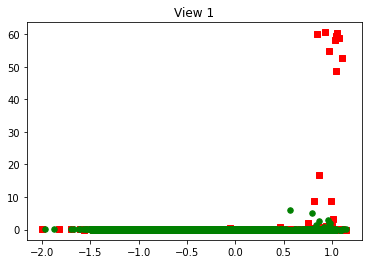

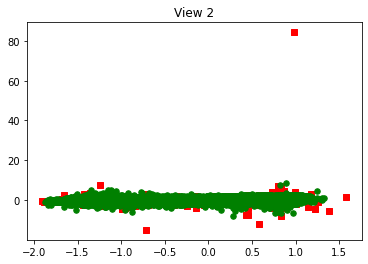

线性LR在X1数据集上的精确度： 78.09 %
非线性SVM在X1数据集上的精确度： 77.93666666666667 %
线性LR在X2数据集上的精确度： 77.88000000000001 %
非线性SVM在X2数据集上的精确度： 77.91 %
acc1LR 0.7801666666666667
acc2LR 0.7775
acc1SVM 0.7781666666666667
acc2SVM 0.7771666666666667


In [11]:
train_a = torch.from_numpy(train_a1).double()
train_b = torch.from_numpy(train_b1).double()


if __name__ == '__main__':

    device = torch.device('cuda')
    #输出的维度
    outdim_size = 2

    # 两个view的输入
    input_shape1 = 11
    input_shape2 = 12

    # 网络架构设置
    layer_sizes1 = [25, 50, 25, outdim_size]
    layer_sizes2 = [25, 50, 25, outdim_size]

    # 超参数设置
    learning_rate = 1e-3
    epoch_num = 20000
    reg_par = 1e-5
    use_all_singular_values = False
    apply_linear_cca = True

    model = DeepCCA(layer_sizes1, layer_sizes2, input_shape1,
                    input_shape2, outdim_size, use_all_singular_values, device=device).double()
    l_cca = None
    if apply_linear_cca:
        l_cca = linear_cca()
    solver = Solver(model, l_cca, outdim_size, epoch_num,
                    learning_rate, reg_par, device=device)
    train1, train2 = train_a, train_b

    solver.fit(train1, train2)

    loss, outputs = solver.test(train1, train2, apply_linear_cca)

    #可视化X1映射到隐空间中的状态，尾数1代表View 1
    visualization_LR(outputs[0], y, 'View 1')
    #可视化X2映射到隐空间中的状态，尾数2代表View 2
    visualization_LR(outputs[1], y, 'View 2')
    
    print("线性LR在X1数据集上的精确度：", acc(LR(numpy.mat(outputs[0]), y)[2], y) * 100, '%')
    print("非线性SVM在X1数据集上的精确度：", acc(svm(outputs[0], y).predict(outputs[0]), y) * 100, '%')
    print("线性LR在X2数据集上的精确度：", acc(LR(numpy.mat(outputs[1]), y)[2], y) * 100, '%')
    print("非线性SVM在X2数据集上的精确度：", acc(svm(outputs[1], y).predict(outputs[1]), y) * 100, '%')
    print("acc1LR", LR_2(outputs[0], y))
    print("acc2LR", LR_2(outputs[1], y))
    print("acc1SVM", svm_2(outputs[0], y))
    print("acc2SVM", svm_2(outputs[1], y))

In [6]:
import seaborn as sns
df = pd.read_csv("cs-training.csv")
df = df.drop("Unnamed: 0", axis=1) # drop id column
df = df.loc[df["DebtRatio"] <= df["DebtRatio"].quantile(0.975)]
df = df.loc[(df["RevolvingUtilizationOfUnsecuredLines"] >= 0) & (df["RevolvingUtilizationOfUnsecuredLines"] < 13)]
df = df.loc[df["NumberOfTimes90DaysLate"] <= 17]
dependents_mode = df["NumberOfDependents"].mode()[0]
df["NumberOfDependents"] = df["NumberOfDependents"].fillna(dependents_mode)
income_median = df["MonthlyIncome"].median()
df["MonthlyIncome"] = df["MonthlyIncome"].fillna(income_median)
X = df.drop("SeriousDlqin2yrs", axis=1)
Y = df["SeriousDlqin2yrs"]
Y.shape

(145755,)